In [1]:
import os
import pandas as pd

# โฟลเดอร์ต้นทางและเป้าหมาย
source_folder = "./data1"  # เปลี่ยนเป็นโฟลเดอร์ที่เก็บไฟล์จริง
target_folder = "./modified_data"

# สร้างโฟลเดอร์ใหม่หากยังไม่มี
os.makedirs(target_folder, exist_ok=True)

# อ่านไฟล์ทั้งหมดในโฟลเดอร์
for file_name in os.listdir(source_folder):
    if file_name.endswith(".csv"):
        file_path = os.path.join(source_folder, file_name)

        # อ่านข้อมูล CSV
        df = pd.read_csv(file_path)

        # แยกชื่อไฟล์ออกจาก .csv และเพิ่ม "-USD"
        base_name = os.path.splitext(file_name)[0]  # ตัด .csv ออก
        new_file_name = f"{base_name}-USD.csv"  # เพิ่ม -USD

        # บันทึกไฟล์ใหม่ใน target_folder
        output_path = os.path.join(target_folder, new_file_name)
        df.to_csv(output_path, index=False)

        print(f"✅ Saved: {new_file_name} to {target_folder}")


C:\Users\ไพรัตน์\AppData\Local\Temp\ipykernel_2380\2818860997.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


✅ Saved: ADA-USD.csv to ./modified_data
✅ Saved: AVAX-USD.csv to ./modified_data
✅ Saved: BNB-USD.csv to ./modified_data
✅ Saved: BTC-USD.csv to ./modified_data
✅ Saved: DOGE-USD.csv to ./modified_data
✅ Saved: DOT-USD.csv to ./modified_data
✅ Saved: ETH-USD.csv to ./modified_data
✅ Saved: LINK-USD.csv to ./modified_data
✅ Saved: LTC-USD.csv to ./modified_data
✅ Saved: LUNA-USD.csv to ./modified_data
✅ Saved: MATIC-USD.csv to ./modified_data
✅ Saved: PEPE-USD.csv to ./modified_data
✅ Saved: SHIB-USD.csv to ./modified_data
✅ Saved: SOL-USD.csv to ./modified_data
✅ Saved: UNI-USD.csv to ./modified_data
✅ Saved: USDT-USD.csv to ./modified_data
✅ Saved: XRP-USD.csv to ./modified_data


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\ไพรัตน์\AppData\Local\Temp\ipykernel_2380\2201972307.py:21: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_sentiment["date"] = pd.to_datetime(df_sentiment["date"]).dt.date  # แปลงเป็น Date เท่านั้น
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*********************

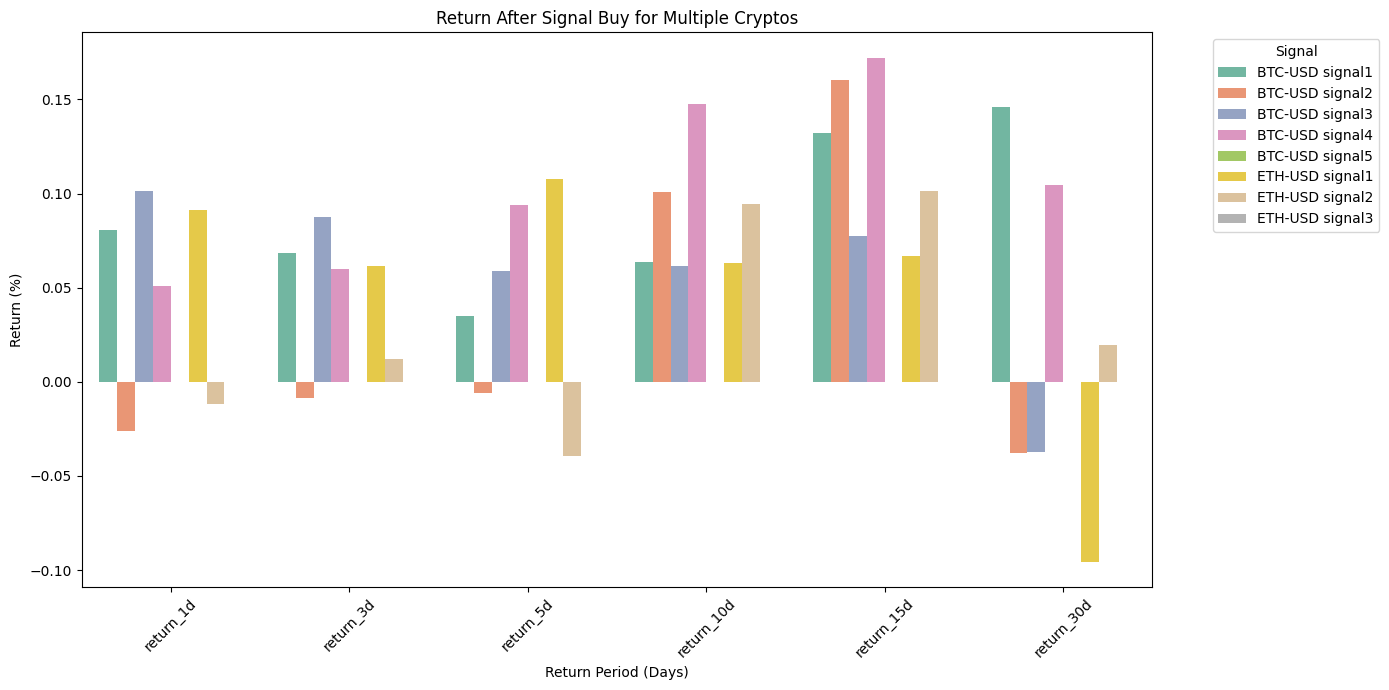

In [2]:
import os
import shutil
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns

def load_crypto_data(symbol, start_date="2024-02-05", end_date="2025-02-05"):
    """โหลดข้อมูลราคาคริปโตจาก Yahoo Finance"""
    data = yf.download(symbol, start=start_date, end=end_date, interval='1d')
    data.columns = data.columns.get_level_values(0)
    df = data.copy().reset_index()
    df.rename(columns={"Date": "date"}, inplace=True)
    df["date"] = pd.to_datetime(df["date"]).dt.normalize()  # ตัดเวลาออก
    return df

def load_sentiment_data(filename, start_date="2024-02-05", end_date="2025-02-05"):
    """โหลดและประมวลผลข้อมูล Sentiment"""
    df_sentiment = pd.read_csv(filename)
    df_sentiment["date"] = pd.to_datetime(df_sentiment["date"]).dt.date  # แปลงเป็น Date เท่านั้น
    df_filtered = df_sentiment[(df_sentiment["date"] >= pd.to_datetime(start_date).date()) & 
                               (df_sentiment["date"] <= pd.to_datetime(end_date).date())]
    daily_sentiment = df_filtered.groupby(["date", "sentiment"]).size().unstack(fill_value=0)
    daily_sentiment["Positive - Negative"] = daily_sentiment.get("Positive", 0) - daily_sentiment.get("Negative", 0)
    return daily_sentiment.reset_index()

def merge_data(df_prices, df_sentiment):
    """รวมข้อมูลราคากับข้อมูล Sentiment"""
    df_prices["date"] = pd.to_datetime(df_prices["date"]).dt.date  # แปลง date เป็น Date เท่านั้น
    df_sentiment["date"] = pd.to_datetime(df_sentiment["date"]).dt.date  # แปลง date เป็น Date เท่านั้น
    df_merged = pd.merge(df_prices, df_sentiment, on="date", how="left").fillna(0)
    return df_merged

def generate_signal(df):
    """สร้าง Signal Buy"""
    df["signal_buy"] = 0
    high_negative_days = df[df["Positive - Negative"] < -30].index
    for idx in high_negative_days:
        future_days = df.loc[idx+1:]
        positive_day = future_days[future_days["Positive - Negative"] > 0]
        if not positive_day.empty:
            first_positive_idx = positive_day.index[0]
            df.loc[first_positive_idx, "signal_buy"] = 1  
    return df

def calculate_returns(df):
    """คำนวณ Return ตามช่วงเวลา 1, 3, 5, 10, 15, 30 วัน"""
    for days in [1, 3, 5, 10, 15, 30]:
        df[f"return_{days}d"] = None
    signal_days = df[df["signal_buy"] == 1].index
    for idx in signal_days:
        entry_idx = idx + 1  
        if entry_idx < len(df):  
            entry_price = df.loc[entry_idx, "Open"]  
            for days in [1, 3, 5, 10, 15, 30]:
                future_idx = entry_idx + days  
                if future_idx < len(df):  
                    future_price = df.loc[future_idx, "Close"]  
                    return_value = (future_price - entry_price) / entry_price  
                    df.loc[idx, f"return_{days}d"] = return_value  
    return df

def plot_returns(crypto_data):
    """Plot กราฟแยกเหรียญ แสดง Return หลังจาก Signal Buy"""
    # Create an empty dataframe to hold the combined data
    combined_data = pd.DataFrame()

    # Loop through each symbol to generate returns for each signal
    for symbol, df in crypto_data.items():
        df_plot = df[df["signal_buy"] == 1][["date", "return_1d", "return_3d", "return_5d", "return_10d", "return_15d", "return_30d"]]
        
        # ตรวจสอบว่า df_plot มีข้อมูลที่ต้องการหรือไม่
        if df_plot.empty:
            continue
        
        # Adding symbol and signal number to differentiate each signal
        signal_idx = df_plot.index
        signal_number = 1
        for idx in signal_idx:
            df_plot.loc[idx, "signal"] = f"{symbol} signal{signal_number}"
            signal_number += 1
        
        # Melting the dataframe to long format for seaborn plotting
        df_melted = df_plot.melt(id_vars=["date", "signal"], var_name="Return Period", value_name="Return")

        # Append to combined data
        combined_data = pd.concat([combined_data, df_melted], ignore_index=True)

    # Check if the combined data has the necessary columns before plotting
    if "signal" not in combined_data.columns or "Return Period" not in combined_data.columns:
        raise ValueError("Missing required columns in the data for plotting.")

    # Plot using seaborn
    plt.figure(figsize=(14, 7))
    sns.barplot(data=combined_data, x="Return Period", y="Return", hue="signal", palette="Set2")
    plt.title("Return After Signal Buy for Multiple Cryptos")
    plt.xlabel("Return Period (Days)")
    plt.ylabel("Return (%)")
    plt.xticks(rotation=45)
    plt.legend(title="Signal", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



# 🚀 ดึงรายชื่อไฟล์ Sentiment จากโฟลเดอร์ modified_data
modified_data_path = "modified_data"
processed_data_path = "processed_data"
os.makedirs(processed_data_path, exist_ok=True)

crypto_symbols = []
sentiment_files = [f for f in os.listdir(modified_data_path) if f.endswith(".csv")]
for file in sentiment_files:
    symbol = file.split("_")[-1].replace(".csv", "")
    crypto_symbols.append(symbol)
    new_filename = f"crypto_sentiment_{symbol}.csv"
    # ใช้ shutil.copy แทน shutil.move เพื่อคัดลอกไฟล์
    shutil.copy(os.path.join(modified_data_path, file), os.path.join(processed_data_path, new_filename))

# 🚀 ดึงข้อมูลของหลายเหรียญและจัดเก็บใน Dictionary
crypto_data = {}
for symbol in crypto_symbols:
    df_prices = load_crypto_data(symbol)
    df_sentiment = load_sentiment_data(os.path.join(processed_data_path, f"crypto_sentiment_{symbol}.csv"))
    df_merged = merge_data(df_prices, df_sentiment)
    df_merged = generate_signal(df_merged)
    df_merged = calculate_returns(df_merged)
    crypto_data[symbol] = df_merged

# 📊 Plot กราฟแยกเหรียญ
plot_returns(crypto_data)
